# Machine learning modeling of superconducting critical temperature

Valentin Stanev, Corey Oses, A. Gilad Kusne, Efrain Rodriguez, Johnpierre Paglione, Stefano Curtarolo and Ichiro Takeuchi

# Highlights

The concept of superconductivity is still in its infancy. Identifying compounds which have properties of superconductity take meticulous experimentation and calculation before they can be approved. The advent of Machine Learning (ML) is proving to be a very scalable solution to this challenge. Utilizing the core principles of ML we can try to find and learn the pattern which most describes superconductivity. The following problem is divided into a classification and a regression task to model the various attributes of superconductivity. The models along with necessary data fusion is done to achive a highly discerning ML pipeline.  

Classifier here performs a binary classification, contrasting between two classes namely above $T_{c}$ and below $T_{c}$. It is a well known fact that most superconducting material tend to have a higher critical temperature $T_{c}$. The classifier attempts to learn the properties which are highly important to superconductors. The regression model on the other hand is used to understand the factors which give it a high $T_c$ for different types of compunds the three main categories being (i) Iron based (ii) Cuprates and (iii) non-iron and non-cuprate compounds (also called low-$T_c$ compounds). 

The idea is to use both these approaches and try to find new compounds in the ICSD database in the low-$T_c$ category which behave as super conductor. The main paper has identified around 30 new potential superconductors which have been approved for experimentation based on these results. 


# Data description

All the data has been extracted through the supplementary scripts provided along with this notebook. 

**Supercon**

This entire project heavily relies on the Supercon database one of the largest repositories of superconductors in the world. The database itself contains the name of the compounds that have been identified as superconductors along with some non superconducting compounds added to remove any algorithmic bias it may generate. The compounds come in a tuple with the critical temperature which we will later discretize to make classes. 

**Magpie (Materials Agnostic Platform for Informatics and Exploration)** 

Since the supercon dataset is almost not usable with any ML algorithm with the lack of data and relevant features we must rely on Magpie to get relevant actionable features for classification and regression. Magpie provides a set of 145 features which are derived from 22 base features which strongly encapsulate the chemical composition of the various compounds. 

**AFLOWlib** 

These provide another set of 23 features such as lattice type, egap etc which encompass the structural and electronic band properties of the material. While not a lot of samples match the supercon data the few samples which do match tend to have very useful properties which can be fused with magpie to give more better results.

**ICSD** 

Contains the dataset of crystalline inorganic compounds. For the purpose of this notebook we will not be looking at this dataset as it was unavailable upon direct request. 


# Algorithm Psuedocode

This paper uses the classification and regression variation of **Random Forests**. The authors state that the algorithm does not make any assumptions about the data and is also very robust to changes, hence their choice of algorithm.

Below I have explained the general approach for both variations and where they differ



**General Random Forests(X,y)**:

step 1 $\rightarrow$ Make subsamples from the sample set with replacement of the X and y tuples. (Replacement is important) 

step 2 $\rightarrow$ For each of the subsample constructed we invoke a decision tree and n such trees on the whole. 

step 3 $\rightarrow$ Each decision tree will choose a set number of features from the total m features which it will use to split data.  

step 4 $\rightarrow$ Each decision tree is try to achieve purity in each leaf with some splitting criteria such as Gini Impurity

step 5 $\rightarrow$ When the decision tree has either reached the defined depth d or has pure leaf nodes it can show a result 

step 6 $\rightarrow$ In case of classification the result of a decision tree is based on the most purest class which it can produce from all the leaf nodes and in case of regression we take the mean of all the leafs node labels to give an approximate guess of the result. 

step 7 $\rightarrow$ Since we are employing these n decision trees in an ensemble setting that means we take the label or result of the majority vote of all the decision trees.

step 8 $\rightarrow$ This majority vote result is the output returned by the decision tree



# Implementation

In [34]:
%matplotlib inline
import numpy as np
import math
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data/Supercon_data.csv')
#data[data['Tc']==0]

In [3]:
def segregate_composition(x):    
    
    if 'Fe' in x:
        composition = 'Iron'
    elif 'Cu' in x:
        composition = 'Cuprate'
    else:
        composition = 'low-Tc'
    return composition

In [4]:
data['composition'] = data['name'].apply(segregate_composition)
data_zeroTc = data[data['Tc']<=0]
data_Tc = data[data['Tc']>0]
data

,name,Tc,composition
0,Ba0.4K0.6Fe2As2,31.20,Iron
1,Ca0.4Ba1.25La1.25Cu3O6.98,40.10,Cuprate
2,Mo0.39Ru0.61,6.90,low-Tc
3,Tm4Os6Sn19,1.10,low-Tc
4,Nd1Bi0.99Pb0.01S2F0.3O0.7,4.85,low-Tc
...,...,...,...
16409,Al4C3,0.00,low-Tc
16410,Nb0.96Ta0.04,8.87,low-Tc
16411,Pb2Sr2Ho0.5Ca0.5Cu2.982Al0.018O8,63.60,Cuprate
16412,Yb0.5Pr0.5Ba2Cu3O6.9,34.80,Cuprate


In [5]:
data[data['composition']=='low-Tc']

,name,Tc,composition
2,Mo0.39Ru0.61,6.900,low-Tc
3,Tm4Os6Sn19,1.100,low-Tc
4,Nd1Bi0.99Pb0.01S2F0.3O0.7,4.850,low-Tc
5,V0.784Ga0.172Al0.044,9.400,low-Tc
7,Re0.1W0.9,0.000,low-Tc
...,...,...,...
16406,Mo0.9Re0.1,2.945,low-Tc
16407,Pt2Y3,0.900,low-Tc
16409,Al4C3,0.000,low-Tc
16410,Nb0.96Ta0.04,8.870,low-Tc


In [376]:
max_bin = max(list(data_Tc['Tc']))
bins = math.ceil(max_bin/2)
fig = px.histogram(data_Tc, x='Tc', nbins=bins,color='composition')
fig.show()
log_tc = data[data.Tc>10].copy(deep=True)
log_tc['log_value'] = np.log(log_tc['Tc'])
fig = px.histogram(log_tc, x='log_value', nbins=54)
fig.show()


The two figures recreate Figure 2a of the paper. The first figure shows a histogram of the different types of compounds in superconductors mapped with the crtical temperature $T_c$. The second figure below is the same data represented on a log scale $ln(T_c)$. 

In [8]:
magpie_features = pd.read_csv('data/Magpie_data.csv',index_col=[0])
magpie_features

,NComp,Comp_L2Norm,Comp_L3Norm,Comp_L5Norm,Comp_L7Norm,Comp_L10Norm,mean_Number,maxdiff_Number,dev_Number,max_Number,...,min_SpaceGroupNumber,most_SpaceGroupNumber,frac_sValence,frac_pValence,frac_dValence,frac_fValence,CanFormIonic,MaxIonicChar,MeanIonicChar,name
0,4,0.583781,0.506891,0.459606,0.441643,0.428710,30.360000,37,6.214400,56,...,166,197.5,0.198312,0.126582,0.675105,0.000000,0,0.370230,0.101293,Ba0.4K0.6Fe2As2
1,5,0.606413,0.557901,0.543545,0.542136,0.541937,22.677795,49,16.074864,57,...,12,12.0,0.277798,0.340779,0.381423,0.000000,0,0.803211,0.321647,Ca0.4Ba1.25La1.25Cu3O6.98
2,2,0.724017,0.659084,0.622509,0.613736,0.610693,43.220000,2,0.951600,44,...,194,194.0,0.138504,0.000000,0.861496,0.000000,0,0.000400,0.000190,Mo0.39Ru0.61
3,3,0.700772,0.663969,0.655637,0.655203,0.655173,58.000000,26,10.482759,76,...,141,141.0,0.126638,0.082969,0.493450,0.296943,0,0.201983,0.036805,Tm4Os6Sn19
4,6,0.512258,0.435720,0.405168,0.400893,0.400075,36.658000,75,27.869600,83,...,12,70.0,0.187652,0.286921,0.187652,0.337774,0,0.866866,0.228340,Nd1Bi0.99Pb0.01S2F0.3O0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16409,2,0.714286,0.642563,0.596290,0.581749,0.574568,10.000000,7,3.428571,13,...,194,225.0,0.583333,0.416667,0.000000,0.000000,1,0.198203,0.097079,Al4C3
16410,2,0.960833,0.960023,0.960000,0.960000,0.960000,42.280000,32,2.457600,73,...,229,229.0,0.187050,0.000000,0.712230,0.100719,0,0.002497,0.000192,Nb0.96Ta0.04
16411,7,0.563862,0.513551,0.500912,0.500080,0.500003,27.138250,74,19.616202,82,...,12,12.0,0.195597,0.242781,0.335814,0.225808,0,0.787757,0.293656,Pb2Sr2Ho0.5Ca0.5Cu2.982Al0.018O8
16412,5,0.605991,0.553369,0.536752,0.535121,0.534897,24.705426,62,17.870921,70,...,12,12.0,0.256468,0.310461,0.337458,0.095613,0,0.803211,0.324919,Yb0.5Pr0.5Ba2Cu3O6.9


In [9]:
magpie_data = data.merge(magpie_features,on='name')
magpie_data


,name,Tc,composition,NComp,Comp_L2Norm,Comp_L3Norm,Comp_L5Norm,Comp_L7Norm,Comp_L10Norm,mean_Number,...,max_SpaceGroupNumber,min_SpaceGroupNumber,most_SpaceGroupNumber,frac_sValence,frac_pValence,frac_dValence,frac_fValence,CanFormIonic,MaxIonicChar,MeanIonicChar
0,Ba0.4K0.6Fe2As2,31.20,Iron,4,0.583781,0.506891,0.459606,0.441643,0.428710,30.360000,...,229,166,197.5,0.198312,0.126582,0.675105,0.000000,0,0.370230,0.101293
1,Ca0.4Ba1.25La1.25Cu3O6.98,40.10,Cuprate,5,0.606413,0.557901,0.543545,0.542136,0.541937,22.677795,...,229,12,12.0,0.277798,0.340779,0.381423,0.000000,0,0.803211,0.321647
2,Mo0.39Ru0.61,6.90,low-Tc,2,0.724017,0.659084,0.622509,0.613736,0.610693,43.220000,...,229,194,194.0,0.138504,0.000000,0.861496,0.000000,0,0.000400,0.000190
3,Tm4Os6Sn19,1.10,low-Tc,3,0.700772,0.663969,0.655637,0.655203,0.655173,58.000000,...,194,141,141.0,0.126638,0.082969,0.493450,0.296943,0,0.201983,0.036805
4,Nd1Bi0.99Pb0.01S2F0.3O0.7,4.85,low-Tc,6,0.512258,0.435720,0.405168,0.400893,0.400075,36.658000,...,225,12,70.0,0.187652,0.286921,0.187652,0.337774,0,0.866866,0.228340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16409,Al4C3,0.00,low-Tc,2,0.714286,0.642563,0.596290,0.581749,0.574568,10.000000,...,225,194,225.0,0.583333,0.416667,0.000000,0.000000,1,0.198203,0.097079
16410,Nb0.96Ta0.04,8.87,low-Tc,2,0.960833,0.960023,0.960000,0.960000,0.960000,42.280000,...,229,229,229.0,0.187050,0.000000,0.712230,0.100719,0,0.002497,0.000192
16411,Pb2Sr2Ho0.5Ca0.5Cu2.982Al0.018O8,63.60,Cuprate,7,0.563862,0.513551,0.500912,0.500080,0.500003,27.138250,...,225,12,12.0,0.195597,0.242781,0.335814,0.225808,0,0.787757,0.293656
16412,Yb0.5Pr0.5Ba2Cu3O6.9,34.80,Cuprate,5,0.605991,0.553369,0.536752,0.535121,0.534897,24.705426,...,229,12,12.0,0.256468,0.310461,0.337458,0.095613,0,0.803211,0.324919


In [378]:
X = magpie_features.drop(['name'], axis=1).values
X

array([[4.00000000e+00, 5.83780781e-01, 5.06891252e-01, ...,
        0.00000000e+00, 3.70229619e-01, 1.01293402e-01],
       [5.00000000e+00, 6.06412684e-01, 5.57901057e-01, ...,
        0.00000000e+00, 8.03211356e-01, 3.21646916e-01],
       [2.00000000e+00, 7.24016574e-01, 6.59083515e-01, ...,
        0.00000000e+00, 3.99920011e-04, 1.90281941e-04],
       ...,
       [7.00000000e+00, 5.63861713e-01, 5.13550948e-01, ...,
        0.00000000e+00, 7.87757332e-01, 2.93655829e-01],
       [5.00000000e+00, 6.05991359e-01, 5.53369059e-01, ...,
        0.00000000e+00, 8.03211356e-01, 3.24918995e-01],
       [2.00000000e+00, 7.28868987e-01, 6.67100412e-01, ...,
        0.00000000e+00, 1.47856211e-01, 6.93075989e-02]])

In [127]:
no_trees = 300
depth = 5
sample_split=10
no_features = 145

In [141]:
plotter = pd.DataFrame()
metric_list = []
value_list = []
t_list = []
#plotter['']

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import copy
for t_sep in range(0,40,5):
    
    
    y_pre = magpie_data['Tc'].values
    y = copy.deepcopy(y_pre)
    
    for index in range(0,len(y)):
        
        if y[index] > t_sep:
            y[index] = 1
        else:
            y[index] = 0
    
    #print (y)
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,shuffle=True,random_state=42)
    
    #clf = RandomForestClassifier(max_depth=depth, random_state=0,n_estimators=no_trees,min_samples_split=sample_split,max_features=no_features)
    clf = RandomForestClassifier(max_depth=18, random_state=0,n_estimators=no_trees)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    
    metrics = precision_recall_fscore_support(y_test, y_pred, average='binary')
    
    
    value_list.append(accuracy_score(y_test, y_pred))
    metric_list.append('Accuracy')
    t_list.append(t_sep)
    
    value_list.append(metrics[0])
    metric_list.append('Precision')
    t_list.append(t_sep)
    
    value_list.append(metrics[1])
    metric_list.append('Recall')
    t_list.append(t_sep)
    value_list.append(metrics[2])
    metric_list.append('F1 Score')
    t_list.append(t_sep)
    
    
    #print (precision_recall_fscore_support(y_test, y_pred, average='binary'))
    

    

In [142]:
plotter['Metric'] = metric_list
plotter['T_sep'] = t_list
plotter['Value'] = value_list


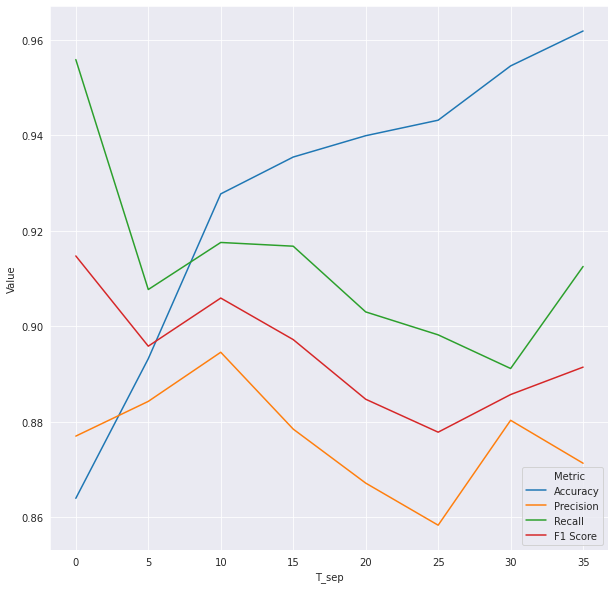

In [143]:
sns.set_style("darkgrid")
plt.figure(figsize=(10, 10))
ax = sns.lineplot(x='T_sep',y='Value',data=plotter,hue='Metric',markers="o")
plt.show()

This figure above is a recreation of the figure 2b from the paper. This shows the accuracy, precision, recall and f1 score as a function of $T_{sep}$. Here any compound which has $T_c > T_{sep}$ is classified as above $T_c$ class and the other as below $T_c$. 

In [379]:
plotter = pd.DataFrame()
metric_list = []
value_list = []
t_list = []
#plotter['']

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import copy
for size in range(1,15000,500):
    
    
    y_pre = magpie_data['Tc'].values
    y = copy.deepcopy(y_pre)
    
    for index in range(0,len(y)):
        
        if y[index] > t_sep:
            y[index] = 1
        else:
            y[index] = 0
    
    #print (y)
    
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,shuffle=False)
    
    #clf = RandomForestClassifier(max_depth=depth, random_state=0,n_estimators=no_trees,max_features=no_features)
    clf = RandomForestClassifier(max_depth=18, random_state=0,n_estimators=no_trees)
    clf.fit(X_train[0:size], y_train[0:size])
    
    y_pred = clf.predict(X_test)
    
    
    metrics = precision_recall_fscore_support(y_test, y_pred, average='binary')
    
    
    value_list.append(accuracy_score(y_test, y_pred))
    metric_list.append('Accuracy')
    t_list.append(size)
    
    value_list.append(metrics[0])
    metric_list.append('Precision')
    t_list.append(size)
    
    value_list.append(metrics[1])
    metric_list.append('Recall')
    t_list.append(size)
    value_list.append(metrics[2])
    metric_list.append('F1 Score')
    t_list.append(size)
    
    
    #print (precision_recall_fscore_support(y_test, y_pred, average='binary'))
    

    

/home/rahulaedula95/summer_research/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



In [380]:
plotter['Metric'] = metric_list
plotter['Size'] = t_list
plotter['Value'] = value_list


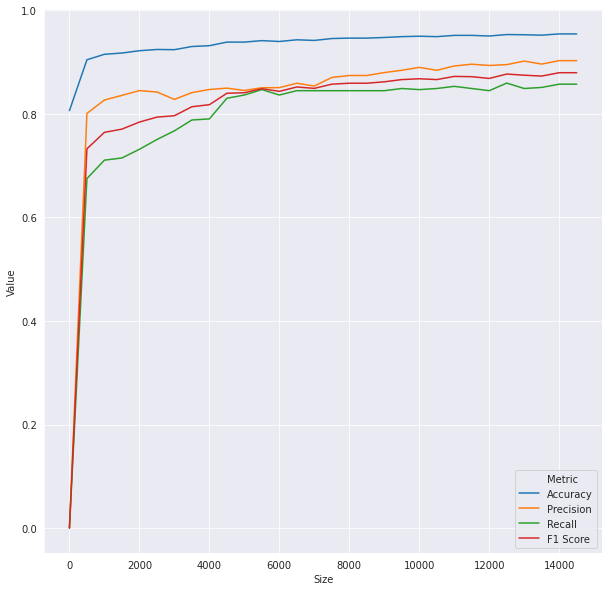

In [381]:
sns.set_style("darkgrid")
plt.figure(figsize=(10, 10))
ax = sns.lineplot(x='Size',y='Value',data=plotter,hue='Metric',markers="o")
plt.show()

This figure above is a recreation of the figure 2c from the paper. This shows the accuracy, precision, recall and f1 score as a function of dataset training size used. 

In [172]:
plotter = pd.DataFrame()
metric_list = []
value_list = []
t_list = []

from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import copy
from sklearn.feature_selection import RFE

y_pre = magpie_data['Tc'].values
y = copy.deepcopy(y_pre)

for index in range(0,len(y)):

    if y[index] > t_sep:
        y[index] = 1
    else:
        y[index] = 0

#print (y)

features = 30

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,shuffle=False)

clf = RandomForestClassifier(max_depth=18, random_state=0,n_estimators=no_trees)
clf.fit(X_train, y_train)  



while features!=0:
    
    imp = clf.feature_importances_
    
    idx = sorted(range(len(imp)), key=lambda i: imp[i], reverse=True)[features:]
    #idx = sorted(range(len(imp)), key=lambda i: imp[i], reverse=True)[:features]
    
    X_train = np.delete(X_train, idx, axis=1)
    X_test = np.delete(X_test, idx, axis=1)
    clf = RandomForestClassifier(max_depth=18, random_state=0,n_estimators=no_trees)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)    
    
    metrics = precision_recall_fscore_support(y_test, y_pred, average='binary')    
    
    value_list.append(accuracy_score(y_test, y_pred))
    metric_list.append('Accuracy')
    t_list.append(features)
    
    value_list.append(metrics[0])
    metric_list.append('Precision')
    t_list.append(features)
    
    value_list.append(metrics[1])
    metric_list.append('Recall')
    t_list.append(features)
    value_list.append(metrics[2])
    metric_list.append('F1 Score')
    t_list.append(features)
    
    features = features - 1
    print (features)
    
    


29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0


In [173]:
plotter['Metric'] = metric_list
plotter['T_sep'] = t_list
plotter['Value'] = value_list


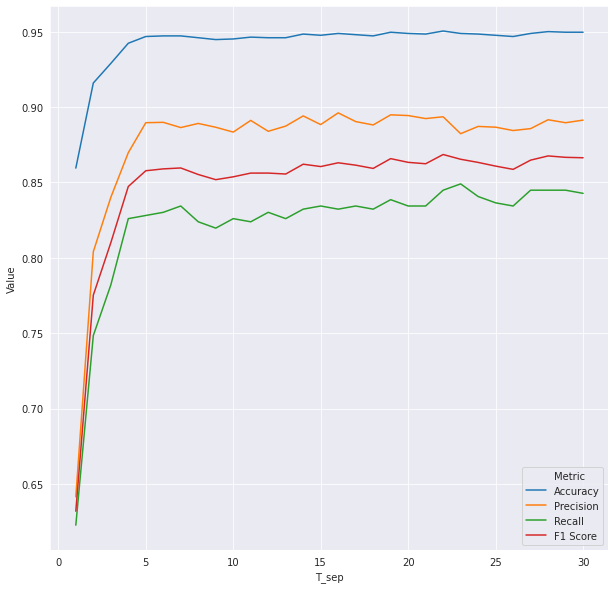

In [174]:
sns.set_style("darkgrid")
plt.figure(figsize=(10, 10))
ax = sns.lineplot(x='T_sep',y='Value',data=plotter,hue='Metric',markers="o")
plt.show()

This figure above is a recreation of the figure 2d from the paper. This shows the accuracy, precision, recall and f1 score as a function of number of features as a result of backwards elimination. 

In [175]:
def make_class(x):
    if x>10:
        return 'Low'
    else:
        return 'Above'
    

In [176]:
magpie_data['Classification'] = magpie_data['Tc'].apply(make_class)

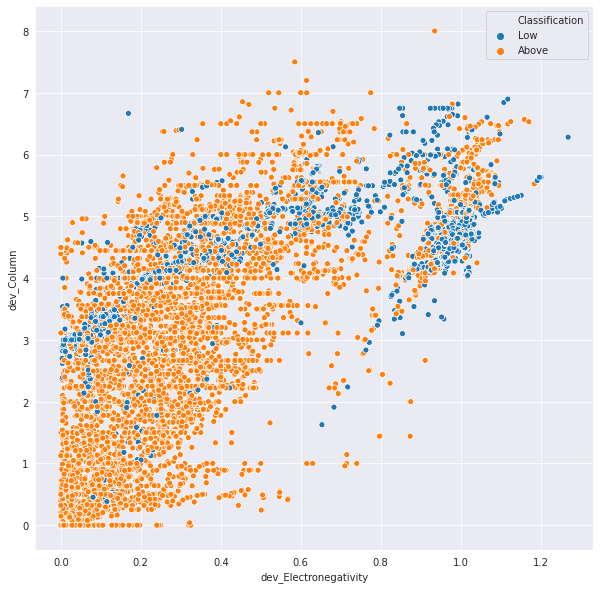

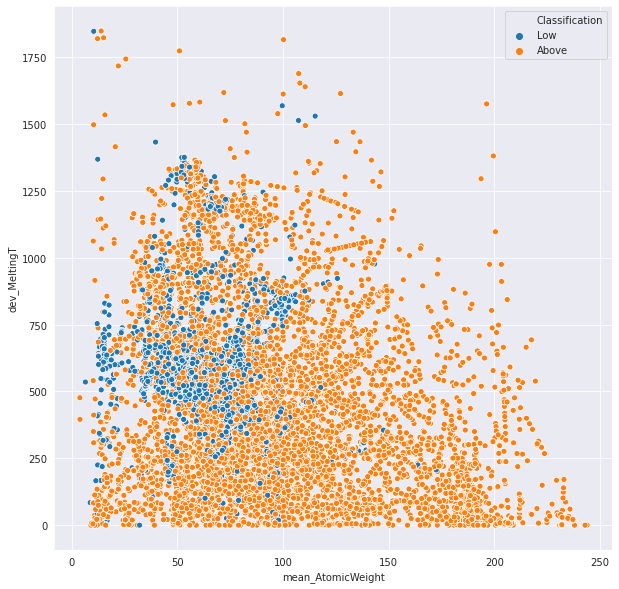

In [382]:
sns.set_style("darkgrid")
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x='dev_Electronegativity',y='dev_Column',data=magpie_data,hue='Classification',markers="o")
plt.show()
sns.set_style("darkgrid")
plt.figure(figsize=(10, 10))
ax = sns.scatterplot(x='mean_AtomicWeight',y='dev_MeltingT',data=magpie_data,hue='Classification',markers="o")
plt.show()

The above two figures are a recreation of Figure 3 from the paper. The figure is a scatterplot obtained from the 4 most important features of the classifier plotted on each axis. 

In [293]:
regression_magpie_data = magpie_data[magpie_data['Tc']>10]
regression_magpie_data

,name,Tc,composition,NComp,Comp_L2Norm,Comp_L3Norm,Comp_L5Norm,Comp_L7Norm,Comp_L10Norm,mean_Number,...,min_SpaceGroupNumber,most_SpaceGroupNumber,frac_sValence,frac_pValence,frac_dValence,frac_fValence,CanFormIonic,MaxIonicChar,MeanIonicChar,Classification
0,Ba0.4K0.6Fe2As2,31.20,Iron,4,0.583781,0.506891,0.459606,0.441643,0.428710,30.360000,...,166,197.5,0.198312,0.126582,0.675105,0.000000,0,0.370230,0.101293,Low
1,Ca0.4Ba1.25La1.25Cu3O6.98,40.10,Cuprate,5,0.606413,0.557901,0.543545,0.542136,0.541937,22.677795,...,12,12.0,0.277798,0.340779,0.381423,0.000000,0,0.803211,0.321647,Low
6,La1.71Sr0.29Cu0.94Co0.06O4,33.00,Cuprate,5,0.637204,0.588349,0.573132,0.571645,0.571440,24.195714,...,12,12.0,0.321754,0.394186,0.284060,0.000000,0,0.787757,0.331360,Low
10,Nb3Sn0.85Tl0.15,18.20,low-Tc,3,0.780425,0.755675,0.750274,0.750016,0.750000,44.412500,...,141,229.0,0.161551,0.059774,0.710824,0.067851,0,0.031881,0.010622,Low
11,Pb0.5Cu0.5Sr0.9La1.1Cu1O5.16,28.10,Cuprate,5,0.609260,0.570818,0.563621,0.563335,0.563319,24.310044,...,12,12.0,0.252704,0.325120,0.317007,0.105168,0,0.787757,0.308349,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16400,Dy1Ba2Cu2.8Zn0.2O6.95,13.00,Cuprate,5,0.604010,0.552695,0.538030,0.536824,0.536686,24.772201,...,12,12.0,0.254125,0.305831,0.330033,0.110011,0,0.803211,0.324969,Low
16401,Bi2Ca2.5Sm0.5Cu2O8.33,22.00,Cuprate,5,0.597462,0.553151,0.543816,0.543403,0.543379,24.242661,...,12,12.0,0.206217,0.282918,0.287811,0.223054,0,0.774266,0.302659,Low
16408,La1.78Sr0.22Cu0.9975Zn0.0025O4,19.25,Cuprate,5,0.642251,0.590552,0.573518,0.571715,0.571446,24.403214,...,12,12.0,0.318825,0.392325,0.288849,0.000000,0,0.787757,0.330678,Low
16411,Pb2Sr2Ho0.5Ca0.5Cu2.982Al0.018O8,63.60,Cuprate,7,0.563862,0.513551,0.500912,0.500080,0.500003,27.138250,...,12,12.0,0.195597,0.242781,0.335814,0.225808,0,0.787757,0.293656,Low


In [294]:
X = regression_magpie_data.drop(['name','composition','Tc','Classification'], axis=1).values
X

array([[4.        , 0.58378078, 0.50689125, ..., 0.        , 0.37022962,
        0.1012934 ],
       [5.        , 0.60641268, 0.55790106, ..., 0.        , 0.80321136,
        0.32164692],
       [5.        , 0.63720371, 0.58834936, ..., 0.        , 0.78775733,
        0.33135991],
       ...,
       [5.        , 0.64225071, 0.59055204, ..., 0.        , 0.78775733,
        0.33067828],
       [7.        , 0.56386171, 0.51355095, ..., 0.        , 0.78775733,
        0.29365583],
       [5.        , 0.60599136, 0.55336906, ..., 0.        , 0.80321136,
        0.324919  ]])

In [300]:
plotter = pd.DataFrame()
from sklearn.ensemble import RandomForestRegressor
y_pre = regression_magpie_data['Tc'].values
y = copy.deepcopy(y_pre)
y = np.log(y)

from sklearn.model_selection import ShuffleSplit
rs = ShuffleSplit(n_splits=1, test_size=.15, random_state=0)

for train_index, test_index in rs.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    pass

X_train = X[train_index]
y_train = y[train_index]
X_test = X[test_index]
y_test = y[test_index]
    


regr = RandomForestRegressor(max_depth=18, random_state=0,n_estimators=no_trees)

regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

plotter['Predicted'] = y_pred
plotter['Actual'] = y_test
#k = le.inverse_transform(X_test[:,0])
composition = regression_magpie_data['composition'].values
plotter['composition'] = composition[test_index]
plotter

,Predicted,Actual,composition
0,4.301921,4.356709,Cuprate
1,4.422086,4.416428,Cuprate
2,4.301251,4.394449,Cuprate
3,3.386321,3.618993,Cuprate
4,4.395471,4.485260,Iron
...,...,...,...
927,4.276586,4.291828,Cuprate
928,3.452098,3.218876,Cuprate
929,3.416800,3.210844,Cuprate
930,2.438927,2.418886,low-Tc


<Figure size 720x720 with 0 Axes>

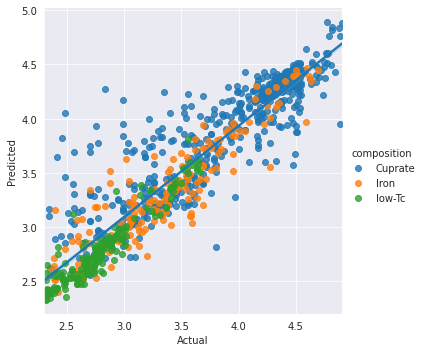

In [305]:
sns.set_style("darkgrid")
plt.figure(figsize=(10, 10))
#ax = sns.lmplot(x='Actual',y='Predicted', hue='composition', data=plotter)
#plt.show()
g = sns.lmplot(x='Actual',y='Predicted', hue='composition', data=plotter, fit_reg=False)
k = sns.regplot(x='Actual',y='Predicted', data=plotter, scatter=False, ax=g.axes[0, 0])
plt.show()

This is a recreation of figure 4a which is the random forest regression. The different compounds are also plotted to as to show the high performance of this model. 

<Figure size 720x720 with 0 Axes>

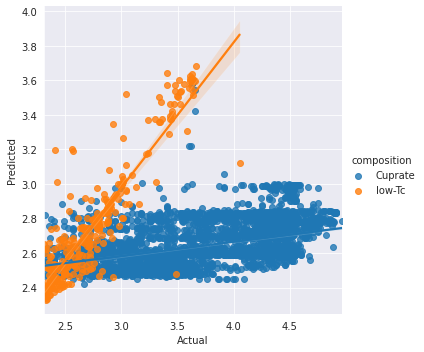

<Figure size 720x720 with 0 Axes>

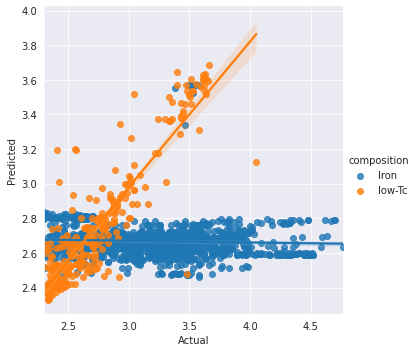

<Figure size 720x720 with 0 Axes>

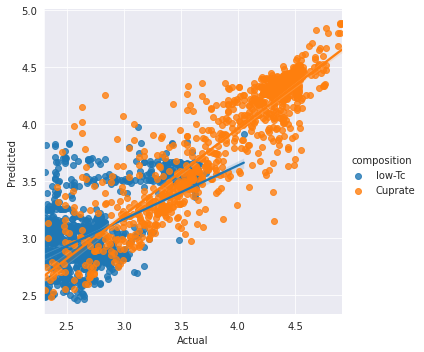

<Figure size 720x720 with 0 Axes>

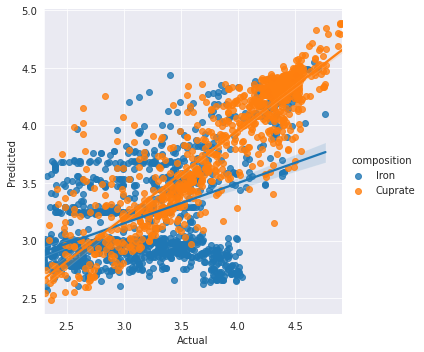

In [330]:
from sklearn.ensemble import RandomForestRegressor

tup = [('Cuprate','low-Tc'),('Iron','low-Tc'),('low-Tc','Cuprate'),('Iron','Cuprate')]



for i,j in tup:

    regression_magpie_data = magpie_data[magpie_data['Tc']>10]
    regression_magpie_test = regression_magpie_data[regression_magpie_data['composition'] == i]
    regression_magpie_train  = regression_magpie_data[regression_magpie_data['composition'] == j]

    plotter = pd.DataFrame()

    X = regression_magpie_train.drop(['name','composition','Tc','Classification'], axis=1).values
    X_non = regression_magpie_test.drop(['name','composition','Tc','Classification'], axis=1).values


    y_pre = regression_magpie_train['Tc'].values
    y = copy.deepcopy(y_pre)
    y = np.log(y)

    y_pre_non = regression_magpie_test['Tc'].values
    y_non = copy.deepcopy(y_pre_non)
    y_non = np.log(y_non)



    rs = ShuffleSplit(n_splits=1, test_size=.25, random_state=0)

    for train_index, test_index in rs.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        pass

    X_train = X[train_index]
    y_train = y[train_index]


    X_test = X[test_index]
    y_test = y[test_index]

    composition = regression_magpie_train['composition'].values
    composition = composition[test_index]

    X_test = np.concatenate((X_non,X_test),axis=0)
    y_test = np.concatenate((y_non,y_test),axis=0)


    composition = np.concatenate((regression_magpie_test['composition'].values,composition),axis=0)


    regr = RandomForestRegressor(max_depth=18, random_state=0,n_estimators=no_trees)

    regr.fit(X_train, y_train)

    y_pred = regr.predict(X_test)

    plotter['Predicted'] = y_pred
    plotter['Actual'] = y_test

    plotter['composition'] = composition

    sns.set_style("darkgrid")
    plt.figure(figsize=(10, 10))
    ax = sns.lmplot(x='Actual',y='Predicted', hue='composition', data=plotter)
    plt.show()


The pictures above are a recreation of figure 4b, 4c, 4d and 4e from the paper. They show the capacity for the random forest regression to learn specific properties of the compounds. In the first two plots only the low-Tc data is trained and is tested with new unseen data and the last two figures do the exact same test with cuprates. 

In [359]:
def identify_type(x):    
    
    if any(c in x for c in ['MG','B2']):
        co_type = 'MgB2-related'
    elif 'Bi' in x:
        co_type = 'bismuthates'
    elif 'C60' in x:
        co_type = 'C60'
    else:
        co_type = 'others'
    return co_type

In [360]:
magpie_data['co_type'] = magpie_data['name'].apply(identify_type)

type_data = magpie_data[magpie_data['composition']=='low-Tc']
type_data = type_data[type_data['Tc']<=40]

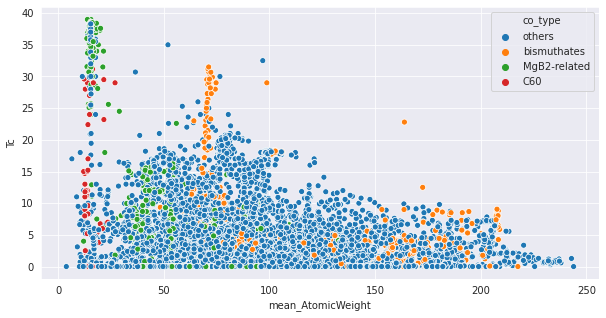

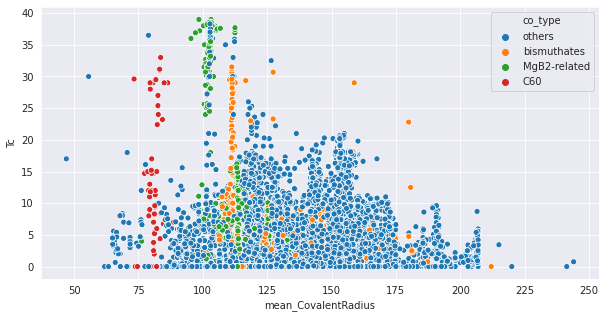

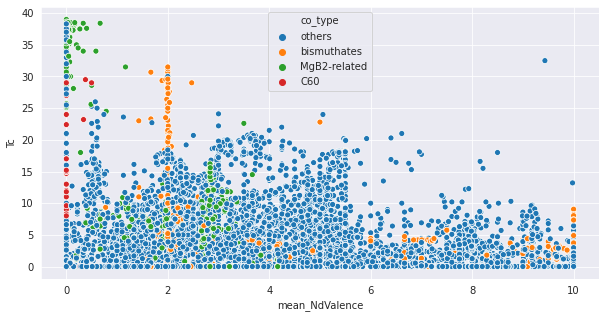

In [361]:
tup = [('mean_AtomicWeight','Tc'),('mean_CovalentRadius','Tc'),('mean_NdValence','Tc')]

for i,j in tup:
    
    sns.set_style("darkgrid")
    plt.figure(figsize=(10, 5))
    ax = sns.scatterplot(x=i,y=j,data=type_data,hue='co_type',markers="o")
    plt.show()

The figures above are a recreation of 5a, 5b, 5c. These show the feature space of other classiication of compounds with some relevant magpie features coupled with $T_c$ 

In [366]:
def identify_type2(x):    
    
    if all(c in x for c in ['Hg','Ba','Ca','Cu','O']):
        co_type = 'Hg-Ba-Ca-Cu-O'
    elif all(c in x for c in ['Tl','Ba','Ca','Cu','O']):
        co_type = 'Tl-Ba-Ca-Cu-O'
    elif all(c in x for c in ['Bi','Sr','Ca','Cu','O']):
        co_type = 'Bi-Sr-Ca-Cu-O'
    elif all(c in x for c in ['Y','Ba','Cu','O']):
        co_type = 'Y-Ba-Cu-O'
    elif all(c in x for c in ['La','Ba','Cu','O']):
        co_type = 'La-Ba-Cu-O'        
    else:
        co_type = 'others'
    return co_type

In [373]:
magpie_data['co_type2'] = magpie_data['name'].apply(identify_type2)
#type_data = magpie_data
type_data = magpie_data[magpie_data['composition']=='Cuprate']
#type_data = type_data[type_data['mean_NUnfilled'] < 6]
#type_data = type_data[type_data['Tc']<=40]

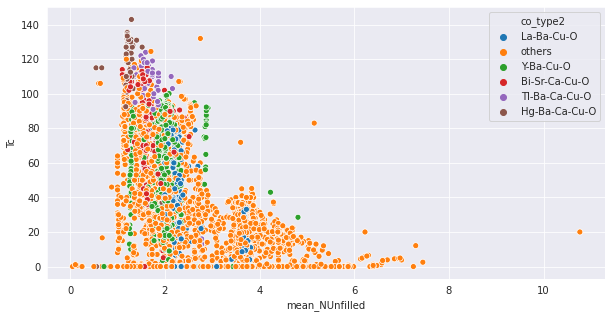

In [374]:
sns.set_style("darkgrid")
plt.figure(figsize=(10, 5))
ax = sns.scatterplot(x='mean_NUnfilled',y='Tc',data=type_data,hue='co_type2',markers="o")
plt.show()

This figure is a recreation of 5d and it is also a feature space representation of a useful magpie feature to $T_c$

<Figure size 720x720 with 0 Axes>

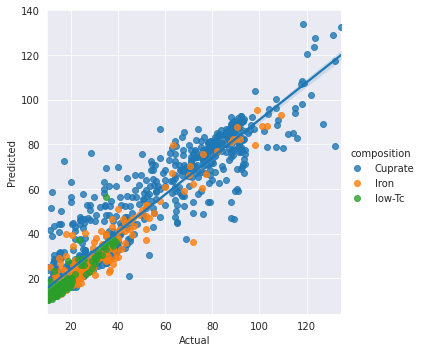

In [375]:
regression_magpie_data = magpie_data[magpie_data['Tc']>10]
X = regression_magpie_data.drop(['name','composition','Tc','Classification','co_type','co_type2'], axis=1).values
plotter = pd.DataFrame()
from sklearn.ensemble import RandomForestRegressor
y_pre = regression_magpie_data['Tc'].values
y = copy.deepcopy(y_pre)
#y = np.log(y)

from sklearn.model_selection import ShuffleSplit
rs = ShuffleSplit(n_splits=1, test_size=.15, random_state=0)

for train_index, test_index in rs.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    pass

X_train = X[train_index]
y_train = y[train_index]
X_test = X[test_index]
y_test = y[test_index]
    


regr = RandomForestRegressor(max_depth=18, random_state=0,n_estimators=no_trees)

regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

plotter['Predicted'] = y_pred
plotter['Actual'] = y_test
#k = le.inverse_transform(X_test[:,0])
composition = regression_magpie_data['composition'].values
plotter['composition'] = composition[test_index]

sns.set_style("darkgrid")
plt.figure(figsize=(10, 10))
#ax = sns.lmplot(x='Actual',y='Predicted', hue='composition', data=plotter)
#plt.show()
g = sns.lmplot(x='Actual',y='Predicted', hue='composition', data=plotter, fit_reg=False)
k = sns.regplot(x='Actual',y='Predicted', data=plotter, scatter=False, ax=g.axes[0, 0])
plt.show()

This figure is a recreation of figure 7 from the paper. This is a demonstration of random forest regressor without performing any log on the critical temperatures so the raw $T_c$'s themselves

# Missed Figures

Figure 6, 8 and 9 could not be reproduced for two main reasons.

(i) Lack of data access to the ICSD 
(ii) Lack of domain knowledge in superconductivity. 

However most of the ML models and figures are implemented as close as possible since there were no parameters given in the paper. 